<a href="https://colab.research.google.com/github/Lokeshgadhi/introonpandas/blob/main/LGBM%20%26%20XGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb

In [9]:
# Load data
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

def preprocess_data(df):
    df = df.copy()

    # Fill missing values using assignment instead of inplace to avoid FutureWarnings
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Drop Cabin (too many missing values) and other non-useful columns
    df = df.drop(['Cabin', 'Name', 'Ticket'], axis=1)

    # Encode categorical features
    label_enc = LabelEncoder()
    df['Sex'] = label_enc.fit_transform(df['Sex'])
    df['Embarked'] = label_enc.fit_transform(df['Embarked'])

    return df

In [10]:
# Preprocess datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# Separate features and target
X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']

# Split training data for evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

params_lgb = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbosity': -1
}

lgb_model = lgb.train(params_lgb, lgb_train, valid_sets=[lgb_train, lgb_eval])

# Predictions and Evaluation
lgb_preds = lgb_model.predict(X_val)
lgb_preds_binary = (lgb_preds > 0.5).astype(int)

# ---------------------- XGBoost ----------------------
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_val)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:54:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: LightGBM
Accuracy: 0.8212
Precision: 0.7838
Recall: 0.7838
F1 Score: 0.7838

Model: XGBoost
Accuracy: 0.7877
Precision: 0.7368
Recall: 0.7568
F1 Score: 0.7467


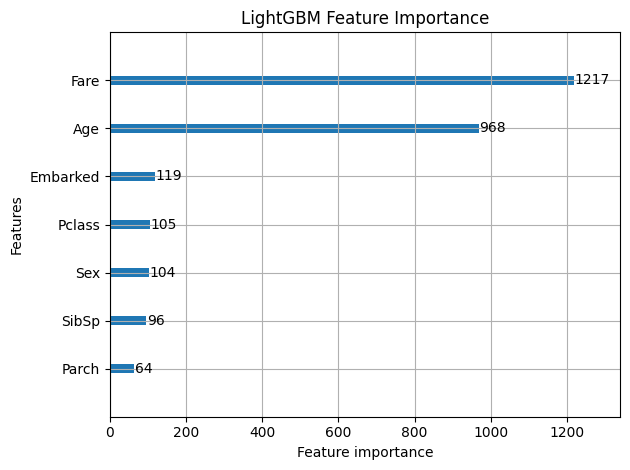

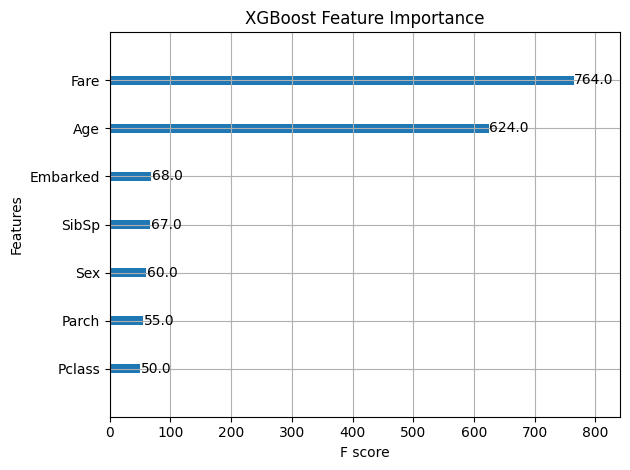

In [12]:
def print_metrics(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_val, lgb_preds_binary, "LightGBM")
print_metrics(y_val, xgb_preds, "XGBoost")

# ---------------------- Feature Importance ----------------------
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()